# The Goal: read a .sav file into Python and interpret
SPSS files, using .sav as their extension, work great if you have the SPSS software. However, that software costs money. So how can we read in the data using Python? Unfortunately .sav files have lots of metadata associated with them, so it's not as simple as converting to .csv and boom you're done. Many cell values are numbers mapped to a specific value (i.e. a `Language` column might have `1` for `English` and `2` for `Spanish`), but you don't know this without reading the metadata. So how can we analyze these .sav files?

This tutorial uses data from the [Survey of American Parents](http://www.pewsocialtrends.org/dataset/survey-american-parents/)

In [5]:
# filepath
filepath_sav = '/Users/adouglas/Google Drive/projects/parenting_survey/data_sep_2015/parenting_clean.sav'
filepath_txt = '/Users/adouglas/Google Drive/projects/parenting_survey/data_sep_2015/parenting_clean.txt'

## First Try: SavReaderWriter
savReaderWriter is a custom package that should allow us to read in .sav files, in fact it was created specifically for this purpose

In [1]:
import savReaderWriter

In [ ]:
# let's just try and get the header information first
with savReaderWriter.SavReader(filepath_sav) as reader:
    header = reader.header

Hmmm, the above code errors out, with error message:

---
`OSError: dlopen(/Users/adouglas/Applications/anaconda/lib/python3.6/site-packages/savReaderWriter/spssio/macos/libicuuc48.1.dylib, 6): Library not loaded: @executable_path/../lib/libicudata48.1.dylib
  Referenced from: /Users/adouglas/Applications/anaconda/lib/python3.6/site-packages/savReaderWriter/spssio/macos/libicuuc48.1.dylib
  Reason: image not found`

---
After a thorough search online to solve this problem, I couldn't come up with a solution (if anyone knows, please drop me a line at alex.douglas4545@gmail.com)

## Second Try: rpy2 package
rpy2 is a Python package that allows one to interface with the R language. It has added benefits like being able to read .sav files.  
*Note: I was unable to get rpy2 working with the most recent package version (as of writing), 3.5.2, so I installed a legacy verion 2.9.5*

I combine the rpy2 package with [this website](https://pspp.benpfaff.org/), which converts the .sav file to csv or txt. Just converting to .csv is super helpful, but like mentioned at the beginning, we need to extract the metadata so that we can map cell values to their original meaning

In [9]:
import pandas as pd
from rpy2.robjects import r

In [6]:
# let's read in our converted .csv file
df = pd.read_csv(filepath_txt)
df.shape

(1807, 185)

In [7]:
# check out the data
df.sample(3)

,psraid,sample,segment,int_date,lang,comp,version,stz,scregion,sstate,...,iphoneuse,hphoneuse,adults,parents,kids,ll,cp,wt1,utweight,weight
1755,401221,2,4,101215,1,1,5,M,4,8,...,3,3,1,1,2,0,1,0.765717,0.98,3.769231
485,200843,2,2,91915,2,1,4,M,4,4,...,3,3,2,2,3,0,1,1.534391,1.47,5.653846
168,101460,1,1,92115,1,1,4,E,3,51,...,2,2,3,1,1,1,1,0.410712,0.45,1.730769


In [10]:
# now we get the mapping using the rpy2 package
data = r('foreign::read.spss("%s")' % filepath_sav)

In [11]:
# the values we want are contained in within the .slots.values() method
mapping = []
for item in data.slots.values():
    mapping.append(item)

In [14]:
# only need first element
mapping = mapping[0]

In [15]:
# let's create a dictionary from this mapping, taking care to avoid any null values 
# (some columns don't have a mapping, like the psraid which is just an id for each survey question)
master_dict = {}
for i in range(len(mapping)):
    if 'RNULLType' not in str(type(mapping[i])):
        master_dict[mapping.names[i]] = {value: key for (key, value) in mapping[i].items()}

In [20]:
# check out our nice mapping
master_dict

{'adults': {3.0: '3 or more', 9.0: 'Undes'},
 'age': {97.0: '97 or older', 99.0: "Don't know/Refused (VOL.)"},
 'attend': {1.0: 'More than once a week',
  2.0: 'Once a week',
  3.0: 'Once or twice a month',
  4.0: 'A few times a year',
  5.0: 'Seldom',
  6.0: 'Never',
  9.0: "Don't know/Refused (VOL.)"},
 'birth_hisp': {1.0: 'U.S.',
  2.0: 'Puerto Rico',
  3.0: 'Another country',
  9.0: "Don't know/Refused (VOL.)"},
 'born': {1.0: 'Yes, would',
  2.0: 'No, would not',
  9.0: "Don't know/Refused (VOL.)"},
 'chage1': {99.0: "Don't know/Refused (VOL.)"},
 'chage2': {5.0: '5 or more', 9.0: "Don't know/Refused (VOL.)"},
 'chage3': {5.0: '5 or more', 9.0: "Don't know/Refused (VOL.)"},
 'chage4': {5.0: '5 or more', 9.0: "Don't know/Refused (VOL.)"},
 'chage5': {1.0: 'R has more than one child under 18 and only one is 6-17',
  2.0: 'R has more than one child under 18 and two or more are 6-17',
  9.0: 'R has more than one child under 18 and we cannot determine how many, if any, are 6-17'},
 'ch

## Let's now apply this mapping to our dataframe, to get a bit more info for each value

In [35]:
# helper function
def get_mapping_value(row, col):
    value = row[col]
    if value in master_dict[col].keys():
        return master_dict[col][value]
    else:
        return value

In [45]:
# iterate through our columns, but only the ones that have a mapping
for col in df.columns:
    if col in master_dict.keys():
        df[col] = df.apply(lambda row: get_mapping_value(row, col), axis=1)

In [46]:
# now how's our dataframe look?
df.sample(3)

,psraid,sample,segment,int_date,lang,comp,version,stz,scregion,sstate,...,iphoneuse,hphoneuse,adults,parents,kids,ll,cp,wt1,utweight,weight
1718,401119,Cell,Cell Callback,101215,English,Completed interview,Revised 9/30,C,Midwest,Kansas,...,Dual,Dual HH,2,2,1 child,1,1,1.209007,1.10,4.230769
221,103090,Landline,LL RDD,92915,English,Completed interview,Revised 9/17,E,Midwest,Indiana,...,LLO,LLO HH,2,2,3 or more,1,0,1.028410,1.32,5.076923
636,202858,Cell,Cell RDD,93015,Spanish,Completed interview,Revised 9/30,E,Northeast,New York,...,CPO,CPO HH,2,2,1 child,0,1,1.534391,3.08,9.846154


## The last bit of mapping we'd like is to see what the full value of the column headers are. i.e. what does 'parents' actually mean within the context of the interview

In [84]:
# we get the labels by again using the rpy2 package, and modifying our query to get the 'variable.labels' attribute
# you can see which 'attributes' are available by running the following
for item in data.list_attrs():
    print(item)

label.table
variable.labels
missings
names
codepage


In [96]:
# get our label text
full_question_text = r('attr(foreign::read.spss("%s"), "variable.labels")' % filepath_sav)
full_question_text = list(full_question_text)

In [97]:
# example, in this case, how did the respondent take the call, cell or landline, coded fully as "Sample type"
full_question_text[1]

'Sample type'

In [98]:
# let's confirm that these line up with the columns in our dataframe
print(len(df.columns))
print(len(full_question_text))

185
186


In [99]:
# uh oh, slight mismatch there, let's zip everything up and see if we can spot inconsistancies
# thinking there's one extra item in our .sav labels that isn't in the dataframe
zipped_items = list(zip(df.columns, full_question_text))
for i in range(len(zipped_items)):
    print(i, zipped_items[i], '\n')

0 ('psraid', 'Unique ID') 

1 ('sample', 'Sample type') 

2 ('segment', 'Sample segment') 

3 ('int_date', 'Interview date') 

4 ('lang', 'Language of interview') 

5 ('comp', 'Completion type') 

6 ('version', 'Version of programmed questionnaire') 

7 ('stz', 'Time zone') 

8 ('scregion', 'Census region - sample') 

9 ('sstate', 'State from FIPS - sample') 

10 ('susr', 'Community type - sample') 

11 ('stimes', 'Number of times to finish survey') 

12 ('filtera', 'FILTER A [parents whose children are all ages 0 to 5]') 

13 ('filterb', 'FILTER B [parents whose children are all all ages 6 to 17]') 

14 ('filterc.1', 'FILTER C [parents with child(ren) ages 0 to 5]') 

15 ('filterc.2', 'FILTER C [parents with child(ren) ages 6 to 17]') 

16 ('llitext0', 'Gender randomization for landline introduction') 

17 ('qs1', 'S1. Are you under 18 years old, OR are you 18 or older?') 

18 ('q1', 'Q.1 Please tell me how satisfied you are with your life overall – would you say you are [READ IN ORDE

In [100]:
# yup, looks like number 164 is mismatched. 'Commnity type' is a .sav label but doesn't correspond to the 
# 'cregion' label in our dataframe. If we remove 'Community type', it looks like everything should line up
full_question_text.remove('Community type')

In [101]:
# let's try that again
print(len(df.columns))
print(len(full_question_text))

zipped_items = list(zip(df.columns, full_question_text))
for i in range(len(zipped_items)):
    print(i, zipped_items[i], '\n')

185
185
0 ('psraid', 'Unique ID') 

1 ('sample', 'Sample type') 

2 ('segment', 'Sample segment') 

3 ('int_date', 'Interview date') 

4 ('lang', 'Language of interview') 

5 ('comp', 'Completion type') 

6 ('version', 'Version of programmed questionnaire') 

7 ('stz', 'Time zone') 

8 ('scregion', 'Census region - sample') 

9 ('sstate', 'State from FIPS - sample') 

10 ('susr', 'Community type - sample') 

11 ('stimes', 'Number of times to finish survey') 

12 ('filtera', 'FILTER A [parents whose children are all ages 0 to 5]') 

13 ('filterb', 'FILTER B [parents whose children are all all ages 6 to 17]') 

14 ('filterc.1', 'FILTER C [parents with child(ren) ages 0 to 5]') 

15 ('filterc.2', 'FILTER C [parents with child(ren) ages 6 to 17]') 

16 ('llitext0', 'Gender randomization for landline introduction') 

17 ('qs1', 'S1. Are you under 18 years old, OR are you 18 or older?') 

18 ('q1', 'Q.1 Please tell me how satisfied you are with your life overall – would you say you are [READ

In [102]:
# looks like everything lines up!
# let's create one last mapping for future use
label_dict = {}
for item in zipped_items:
    label_dict[item[0]] = item[1]

In [103]:
# check out the mapping,
# now we know exactly what 'adults' means!
label_dict['adults']

'# of adults in HH computed from HH1 and HH3'

## Let's do a small bit of EDA now just to show what we can do with our new found mapping

In [104]:
import matplotlib.pyplot as plt
%matplotlib inline

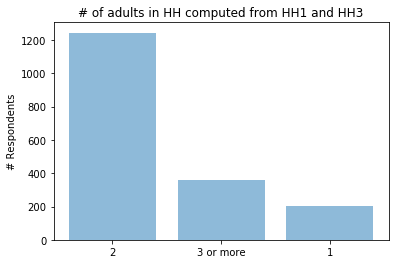

In [122]:
# let's plot that 'adults' column we've been playing with
column = 'adults'
plot_data = df[column].value_counts()
y_pos = list(range(len(plot_data)))
 
plt.bar(y_pos, plot_data.values, align='center', alpha=0.5)
plt.xticks(y_pos, plot_data.index)
plt.ylabel('# Respondents')
plt.title(label_dict[column])
plt.show();

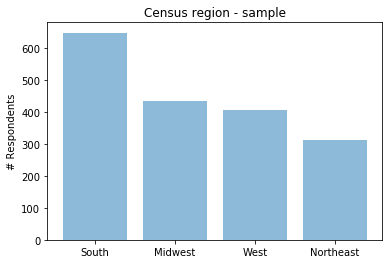

In [123]:
# or what about region?
column = 'scregion'
plot_data = df[column].value_counts()
y_pos = list(range(len(plot_data)))
 
plt.bar(y_pos, plot_data.values, align='center', alpha=0.5)
plt.xticks(y_pos, plot_data.index)
plt.ylabel('# Respondents')
plt.title(label_dict[column])
plt.show();

In [148]:
# or what about histogram of age?
age_dist = df[df['age'] != "Don't know/Refused (VOL.)"]['age']
age_dist = age_dist.replace('97 or older', 97)

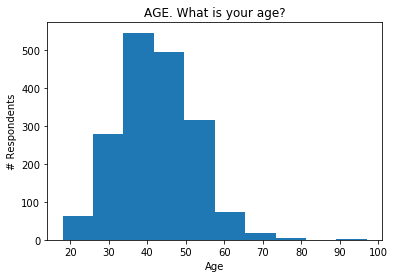

In [150]:
plt.hist(age_dist)
plt.xlabel('Age')
plt.ylabel('# Respondents')
plt.title(label_dict['age'])
plt.show();

In [252]:
# what about satisfaction with life based on how many kids you have?
# requires a bit more work -- let's get the different datasets first
kids_1 = df[df['qp1a'] == 1]['q1'].value_counts().drop("[VOL. DO NOT READ] Don't know/Refused ").astype('float')
kids_2 = df[df['qp1a'] == 2]['q1'].value_counts().drop("[VOL. DO NOT READ] Don't know/Refused ").astype('float')
kids_3 = df[df['qp1a'] == 3]['q1'].value_counts().drop("[VOL. DO NOT READ] Don't know/Refused ").astype('float')
kids_4 = df[(df['qp1a'] != 1) & (df['qp1a'] != 2) & (df['qp1a'] != 3)]['q1'].value_counts().drop("[VOL. DO NOT READ] Don't know/Refused ").astype('float')

In [253]:
# reindex to get our responses in the same order
kids_1 = kids_1.reindex(['Very satisfied ', 'Mostly satisfied ', 'Mostly dissatisfied, or', 'Very dissatisfied'])
kids_2 = kids_2.reindex(['Very satisfied ', 'Mostly satisfied ', 'Mostly dissatisfied, or', 'Very dissatisfied'])
kids_3 = kids_3.reindex(['Very satisfied ', 'Mostly satisfied ', 'Mostly dissatisfied, or', 'Very dissatisfied'])
kids_4 = kids_4.reindex(['Very satisfied ', 'Mostly satisfied ', 'Mostly dissatisfied, or', 'Very dissatisfied'])

In [254]:
# recast as percentages
total = sum(kids_1.values)
for index in kids_1.index:
    kids_1[index] = kids_1[index] / total * 100
    
total = sum(kids_2.values)
for index in kids_2.index:
    kids_2[index] = kids_2[index] / total * 100
    
total = sum(kids_3.values)
for index in kids_3.index:
    kids_3[index] = kids_3[index] / total * 100
    
total = sum(kids_4.values)
for index in kids_4.index:
    kids_4[index] = kids_4[index] / total * 100

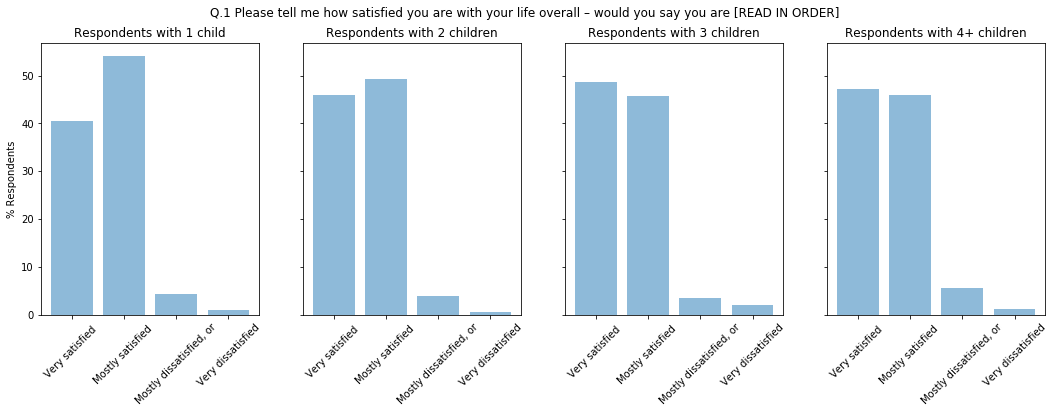

In [255]:
# plot the results
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True)
f.set_figwidth(18)
f.set_figheight(5)
plt.suptitle(label_dict['q1'])
y_pos = list(range(4))

ax1.bar(y_pos, kids_1.values, align='center', alpha=0.5)
ax1.set_xticks(y_pos)
ax1.set_ylabel('% Respondents')
ax1.set_xticklabels(kids_1.index, rotation=45)
ax1.set_title('Respondents with 1 child')

ax2.bar(y_pos, kids_2.values, align='center', alpha=0.5)
ax2.set_xticks(y_pos)
ax2.set_xticklabels(kids_2.index, rotation=45)
ax2.set_title('Respondents with 2 children')

ax3.bar(y_pos, kids_3.values, align='center', alpha=0.5)
ax3.set_xticks(y_pos)
ax3.set_xticklabels(kids_3.index, rotation=45)
ax3.set_title('Respondents with 3 children')

ax4.bar(y_pos, kids_4.values, align='center', alpha=0.5)
ax4.set_xticks(y_pos)
ax4.set_xticklabels(kids_4.index, rotation=45)
ax4.set_title('Respondents with 4+ children')

plt.show();